## Deugging function of unity-based virtual reality rig

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep, isfile, exists
from os import mkdir, makedirs

In [2]:
from unityvr.preproc import logproc
from unityvr.viz import viz, utils

#### Construct data object from log file

In [43]:
#TODO: Add logging of 
# - frame rate
# - ball radius

In [61]:
dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-21_20-22-20.json"

ftlog = 'fictrac-20210121_202559.dat'

setFramerate = 144

In [62]:
uvrTest = logproc.constructUnityVRexperiment(dirName,fileName)
uvrTest.printMetadata()

Metadata:

expid  :  frameratetest
experiment  :  try to read and write to NiDaq (only 1 channel each), 144 Hz framerate
genotype  :  none
sex  :  na
flyid  :  na
date  :  2021-01-21
time  :  20-22-20
notes  :  none


### Check frame rate
#### Basic visualizations

In [63]:
framesDf = uvrTest.nidDf[['frame','time','dt']].drop_duplicates().reset_index(level=0)[['frame','time','dt']]

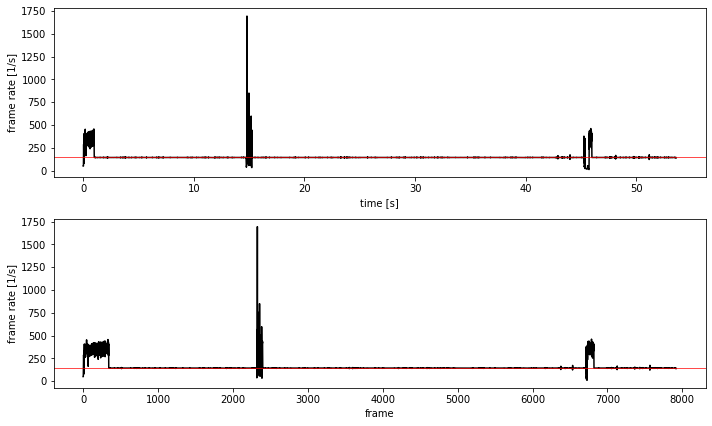

In [64]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(framesDf.time, 1/framesDf.dt, 'k')
ax[1].plot(framesDf.frame, 1/framesDf.dt, 'k')
for i in range(2):ax[i].axhline(setFramerate,0,1,color='r', linewidth=0.7)
utils.addlabs(ax, ['time [s]','frame'], ['frame rate [1/s]','frame rate [1/s]'])
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','framerate_'+fileName.split('.')[0]+'.pdf']))

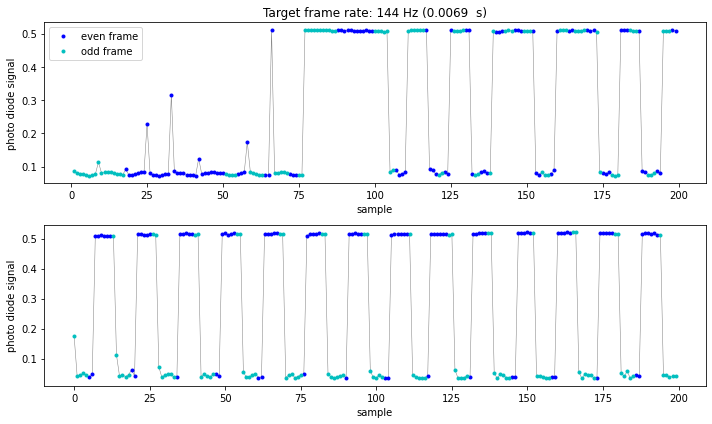

In [65]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
wind = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(wind),uvrTest.nidDf.pdsig[ts:ts+wind],'-',color='grey',linewidth=0.5)
    
    even = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==1]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==1], even.pdsig, 'b.', label='even frame')
    
    odd = uvrTest.nidDf[ts:ts+wind][uvrTest.nidDf['frame'][ts:ts+wind]%2==0]
    ax[i].plot(np.arange(wind)[uvrTest.nidDf['frame'][ts:ts+wind].values%2==0], odd.pdsig, 'c.', label=
              'odd frame')
    
utils.addlabs(ax, ['sample','sample'], ['photo diode signal','photo diode signal'])
ax[0].legend()
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))
fig.tight_layout()

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photodiodeSig_evenframe_'+fileName.split('.')[0]+'.pdf']))

Visualization of delay

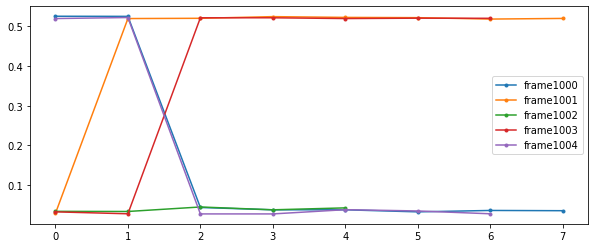

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for f in range(1000,1005):
    sig = uvrTest.nidDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdsig)), sig.pdsig, '.-',  label='frame{}'.format(f))
ax.legend()

#### Quantification of frame rate variation

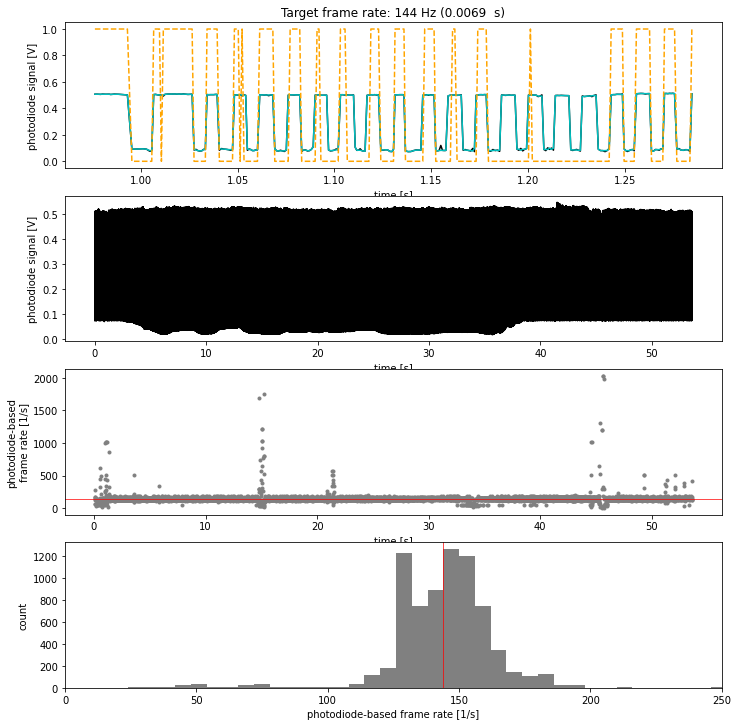

In [67]:
fig, ax = plt.subplots(4,1, figsize=(10,10))
ts = 1000
wind = 300
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdsig[ts:ts+wind], 'k')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdFilt[ts:ts+wind], 'c')
ax[0].plot(uvrTest.nidDf.timeinterp[ts:ts+wind], uvrTest.nidDf.pdThresh[ts:ts+wind], '--',color='orange')

pdChange = np.hstack((0,np.diff(uvrTest.nidDf.pdThresh)))
pdChangeT = uvrTest.nidDf.timeinterp.values[abs( pdChange )>0]

ax[1].plot(uvrTest.nidDf.timeinterp, uvrTest.nidDf.pdsig, 'k')

ax[2].plot(pdChangeT[1:], 1/np.diff(pdChangeT), '.', color='grey')
ax[2].axhline(setFramerate,0,1,color='r', linewidth=0.7)

ax[3].hist(1/np.diff(pdChangeT), bins=50, range=(0, 300), color='grey')
ax[3].set_xlim(0,250)
ax[3].axvline(setFramerate,0,1,color='r', linewidth=0.7)

ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

fig.tight_layout()
utils.addlabs(ax, ['time [s]','time [s]','time [s]','photodiode-based frame rate [1/s]'],
    ['photodiode signal [V]','photodiode signal [V]','photodiode-based\nframe rate [1/s]','count'])

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photdiodeSignal_framerate_'+fileName.split('.')[0]+'.pdf']))

#### Relate unity-based and photodiode signal-based frame rate measures

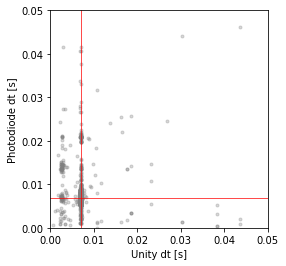

In [68]:
pdChangedt = uvrTest.nidDf.dt.values[abs( pdChange )>0]

fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.plot(np.roll(pdChangedt,0), np.hstack((0,np.diff(pdChangeT))), '.', color='grey', alpha=0.3)
#axs.plot(np.roll(pdChangedt,10), np.hstack((0,np.diff(pdChangeT))), 'r.', alpha=0.5)
axs.set_xlim(0,0.05)
axs.set_ylim(0,0.05)
axs.set_xlabel('Unity dt [s]')
axs.set_ylabel('Photodiode dt [s]')
axs.axvline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.axhline(1/setFramerate,0,1,color='r', linewidth=0.7)
axs.set_aspect('equal')
ax[0].set_title('Target frame rate: {} Hz ({}  s)'.format(setFramerate, round(1/setFramerate, 4)))

utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','unityVsPhotodiode_framerate_'+fileName.split('.')[0]+'.pdf']))

### Compare unityVR trajectory with fictrac trajectory
#### Compare frame rates

Unity log frame rate: 147.65946610021268
Fictrac log frame rate: 123.2278377345442


<ipython-input-69-a2cdaa370377>:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(uvrTest.ftDf.frame,np.hstack([ 0, 1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.) ]), 'c-', label='fictrac frame rate')


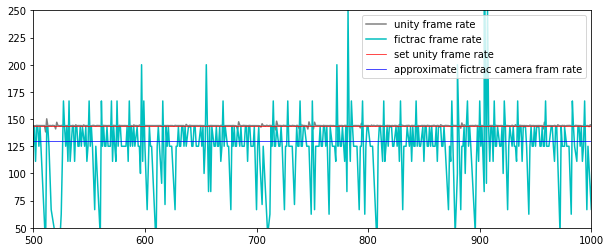

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(uvrTest.posDf.frame, 1/uvrTest.posDf.dt, color='grey', label="unity frame rate")
ax.plot(uvrTest.ftDf.frame,np.hstack([ 0, 1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.) ]), 'c-', label='fictrac frame rate')
print('Unity log frame rate: {}'.format(1/uvrTest.posDf.dt.mean()))
print('Fictrac log frame rate: {}'.format(1/np.diff(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
ax.set_xlim(500,1000)
ax.set_ylim(50,250)
ax.axhline(setFramerate,0,1,color='r', linewidth=0.7, label='set unity frame rate')
ax.axhline(130,0,1,color='b', linewidth=0.7, label="approximate fictrac camera fram rate")
ax.legend()

#### Compare to fictrac data log

In [70]:
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [71]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,9227475105385,0,0,7.355943e+07
1,1,0.009944,0.000258,-0.005641,4035.799747,0.010122,-0.005167,0.001279,0.009944,0.000258,...,-0.010118,6.281907,4.240404,0.011364,-0.005167,-0.010122,9227482702635,1,7597250,7.355944e+07
2,2,-0.005276,0.000232,0.008114,4115.377221,-0.005530,0.007571,-0.002414,0.004667,0.000515,...,-0.004589,0.001135,0.630828,0.009376,0.002405,-0.004592,9227490299844,2,7597209,7.355945e+07
3,3,0.000231,-0.000069,0.002858,4003.916530,0.000139,0.002777,-0.000703,0.004897,0.000452,...,-0.004724,0.001838,6.233246,0.002780,0.005181,-0.004730,9227497897175,3,7597331,7.355945e+07
4,4,0.000904,-0.000247,-0.006184,3971.507474,0.001099,-0.005855,0.001905,0.005802,0.000187,...,-0.005827,6.283118,3.327077,0.005957,-0.000674,-0.005829,9227505494260,4,7597085,7.355946e+07


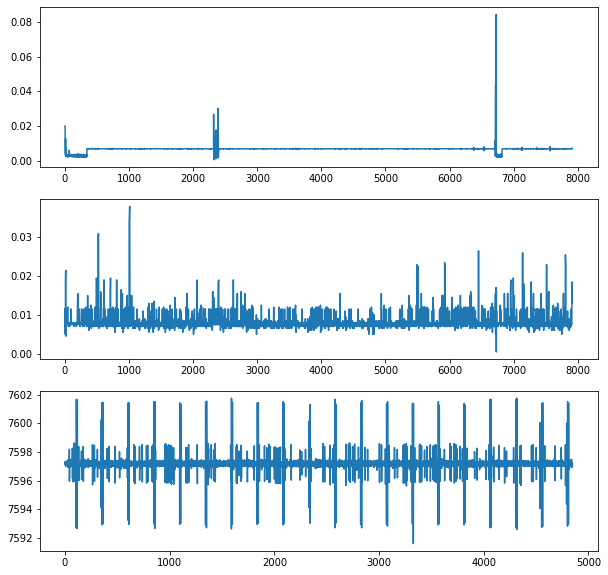

In [72]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame,uvrTest.posDf.dt)
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions
ToDo: interpolate ft to get to frame rate of fictrac --> replace ftdf downsampling function

In [81]:
ballr = 40
convf = ballr #ballr*np.pi/180

fta = np.cumsum(uvrTest.ftDf['dz'])
fty = np.cumsum(convf*uvrTest.ftDf['dy']*np.cos(fta) - convf*uvrTest.ftDf['dx']*np.sin(fta))
ftx = np.cumsum(convf*uvrTest.ftDf['dy']*np.sin(fta) + convf*uvrTest.ftDf['dx']*np.cos(fta))

In [87]:
print(len(fta))
print(len(uvrTest.posDf['x']))

6772
7916


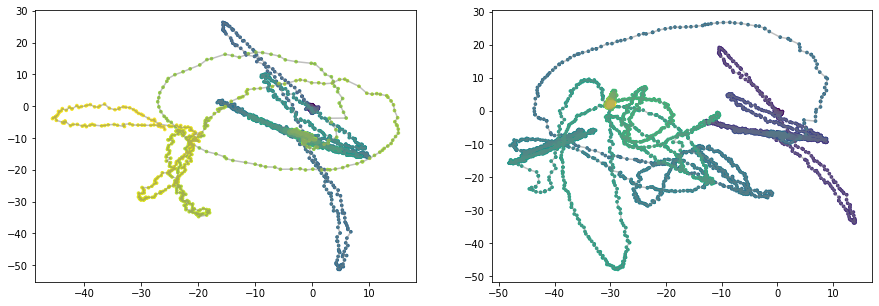

In [84]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

axs[0].plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
axs[0].scatter(ftx[0:3000], fty[0:3000],s=7,c=uvrTest.ftDf['frame'][0:3000],cmap='viridis')

axs[1].plot(uvrTest.posDf['x'], uvrTest.posDf['y'],color='grey',alpha=0.5)
axs[1].scatter(uvrTest.posDf['x'], uvrTest.posDf['y'],s=7,c=uvrTest.posDf['time'],cmap='viridis')

In [76]:
from importlib import reload  
reload(viz)

<module 'unityvr.viz.viz' from '/Users/haberkernh/Documents/GitHub/unityvr/unityvr/viz/viz.py'>

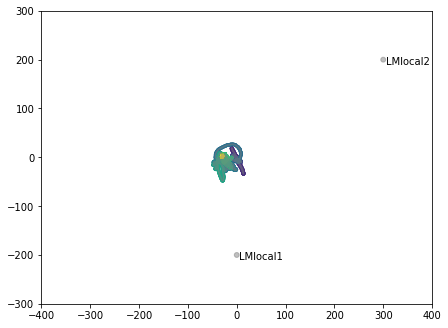

In [77]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-400,400], limy=[-300,300],myfigsize=(7,7))

In [ ]:
utils.makemydir(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','unityVsPhotodiode_framerate_'+fileName.split('.')[0]+'.pdf']))